# Implementação de boosting AdaBoosting Classifier.

### Neste notebooks será implementado o algoritimo AdaBoosting por meio de weak learners com base no algoritmo DecisionTree Classifier da
### biblioteca Sklearn. Toda árvore utilizada tem tamanho 1 (stumps).


## Formulações

### Fator de importância de cada stump (amount_of_saying): 0.5 * log( (1 - ErroTotal + t) / TotalError + t)\
### T = 0.0001 (Pequeno fator de erro artificial para impedir que, caso o stump erre tudo, não aconteça uma divisão por 0.)\

### Equação para aumentar o peso de um sample: sample_weight * e^amount_of_saying
### Equação para diminuir o peso de um sample: sample_weight * e^-amount_of_saying

* Dependências:
    - Jupyterlab
    - numpy
    - matplotlib
    - pandas
    - sklearn


In [12]:
import math
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, precision_score, recall_score
from sklearn.ensemble import AdaBoostClassifier
import matplotlib.pyplot as plt

from tqdm import tqdm

In [13]:
def check(flag):
    return 1 if flag else 0

def encode_data_frame(df):

    le = LabelEncoder()
    for col in df.columns:
        le.fit(df[col])
        df[col] = le.transform(df[col])
    return df

def normalize_data_frame(df, target):

    Y = df[target]
    feats = df.drop(columns=[target])
    values = feats.values
    norms = normalize(values)
    new_df = pd.DataFrame(norms, columns=feats.columns)
    Y = np.where(Y == 0, -1, 1)
    new_df[target] = Y
    return new_df

class Stump():

    def __init__(self, alpha=1):

        self.alpha = alpha
        self.classifier = DecisionTreeClassifier(max_depth=1)
    
    # Atualiza o peso do dado de treino que será usado no próximo stump.
    # Retorna um novo dataset.
    def update_alpha(self, erro_rate, artificial_error=1e-10):

        if erro_rate == 0:
            erro_rate = artificial_error
        res = (1 - erro_rate) / erro_rate
        self.alpha = 0.5 * np.log(res)

class AdaBoost():

    def __init__(self, n_stumps):
        
        self.n_stumps = n_stumps
        self.stumps = [ Stump() for i in range(n_stumps) ]

    # Calcula a taxa de erro e retorna quais instâncias foram classificadas erroneamente.
    def get_error(self, Y_true, Y_pred):

        incorrect = []
        n_erros = 0
        # Para cada instância classificada.
        for y_true, y_pred in zip(Y_true, Y_pred):
            # Se a classificação foi errada.
            if y_true != y_pred:
                n_erros += 1
                # Sinalize com 1: esta instância deve ter mais importância.
                incorrect.append(1)
            else:
                # Sinalize com -1: esta instância deve ter menos importância.
                incorrect.append(-1)
        
        incorrect = np.array(incorrect)
        error_rate = n_erros / len(Y_true)
        return error_rate, incorrect

    def fit(self, X, Y):
        
        weights = np.array([1 / X.shape[0]] * X.shape[0])
        # Treinando os classificadores (stumps).
        for stump in self.stumps:
            # Treinando o stump.
            stump.classifier.fit(X, Y, sample_weight=weights)
            # Medindo a taxa de erro.
            Y_pred = stump.classifier.predict(X)
            error_rate = sum([ w * check(v) for v, w in zip(Y_pred != Y, weights) ]) / sum(weights)
            # Atualizando a influência do stump.
            stump.update_alpha(error_rate)
            # Atualizando o peso das amostras conforme o erro e acerto do stump.
            weights = [ w * np.exp(stump.alpha * check(v)) for v, w in zip(Y_pred != Y, weights) ]

    # Faz a predição com os stumps.
    def predict(self, X):

        # Predizendo.
        stumps_preds = np.array([ stump.classifier.predict(X) for stump in self.stumps ])
        # Reunindo o poder de decisão de cada stump.
        stumps_weights = np.array([ stump.alpha for stump in self.stumps ])

        return np.sign(np.dot(stumps_weights, stumps_preds))
    
    # Faz a predição com os stumps.
    def predict_proba(self, X):

        # Predizendo.
        stumps_preds = np.array([ stump.classifier.predict(X) for stump in self.stumps ])
        # Reunindo o poder de decisão de cada stump.
        stumps_weights = np.array([ stump.alpha for stump in self.stumps ])

        return np.dot(stumps_weights, stumps_preds)

    

    
    

# Analisando o dataset

In [14]:
dataframe = pd.read_csv('data/tic-tac-toe.data', sep=',')
df = dataframe.copy(deep=True)
df.head()

,x,x.1,x.2,x.3,o,o.1,x.4,o.2,o.3,positive
0,x,x,x,x,o,o,o,x,o,positive
1,x,x,x,x,o,o,o,o,x,positive
2,x,x,x,x,o,o,o,b,b,positive
3,x,x,x,x,o,o,b,o,b,positive
4,x,x,x,x,o,o,b,b,o,positive


In [15]:
print("Dataset Size: ", len(df))

Dataset Size:  957


positive    625
negative    332
Name: positive, dtype: int64

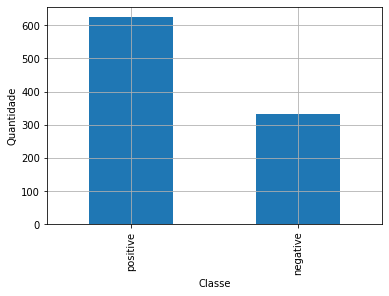

In [16]:
count_class = df.positive.value_counts()
count_class.plot(kind='bar', xlabel="Classe", ylabel="Quantidade", grid=True)
count_class

# Iniciando testes do algoritmo AdaBoosting

In [17]:
# Codificando os dados para valores numéricos.
df = encode_data_frame(df)
df.head()
# Normalizando os dados.
df = normalize_data_frame(df, "positive")
df.head()

,x,x.1,x.2,x.3,o,o.1,x.4,o.2,o.3,positive
0,0.408248,0.408248,0.408248,0.408248,0.204124,0.204124,0.204124,0.408248,0.204124,1
1,0.408248,0.408248,0.408248,0.408248,0.204124,0.204124,0.204124,0.204124,0.408248,1
2,0.458831,0.458831,0.458831,0.458831,0.229416,0.229416,0.229416,0.000000,0.000000,1
3,0.458831,0.458831,0.458831,0.458831,0.229416,0.229416,0.000000,0.229416,0.000000,1
4,0.458831,0.458831,0.458831,0.458831,0.229416,0.229416,0.000000,0.000000,0.229416,1


# Avaliando o modelo

In [18]:
r = np.random
seed = r.randint(0, 2147483647*2)
feats = df.drop(columns=['positive']).values
target = df['positive']


def get_scores(Y_true, Y_pred):
    
    acc = accuracy_score(Y_true, Y_pred)
    prec = precision_score(Y_true, Y_pred)
    recall = recall_score(Y_true, Y_pred)
    f1 = f1_score(Y_true, Y_pred)
    return acc, prec, recall, f1

r = np.random
seed = r.randint(0, 2147483647 * 2)
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)

estimators = {}
best_model = None
best_score = 0

# Para estimaores (stumps) de 1 a N.
for n in tqdm(range(1, n_estimators)):
    # Para cada fold.
    scores = {}
    for train_index, test_index in kf.split(feats):

        X_train, X_test = feats[train_index], feats[test_index]
        Y_train, Y_test = target[train_index], target[test_index]
        # Gerando o modelo.
        adaboost = AdaBoost(n)
        # Treinando o modelo.
        adaboost.fit(X_train, Y_train)
        # Testando o modelo.
        Y_pred = adaboost.predict(X_test)
        # Salvando scores.
        acc = accuracy_score(Y_test, Y_pred)
        acc, prec, recall, f1 = get_scores(Y_test, Y_pred)
        if "acc" not in scores:
            scores["acc"] = 0
            scores["prec"] = 0
            scores["recall"] = 0
            scores["f1"] = 0
        
        scores["acc"] += acc / n_folds
        scores["prec"] += prec / n_folds
        scores["recall"] += recall / n_folds
        scores["f1"] += f1 / n_folds

    estimators[n] = scores
    if estimators[n]["f1"] > best_score:
        best_score = estimators[n]["f1"]
        best_model = n

from pprint import pprint
pprint(estimators)

100%|██████████| 399/399 [22:32<00:00,  3.39s/it]


{1: {'acc': 0.6467931937172775,
     'f1': 0.7546894747990566,
     'prec': 0.6996647200966573,
     'recall': 0.8926829268292683},
 2: {'acc': 0.6541175828970331,
     'f1': 0.6926616378863886,
     'prec': 0.8548567511290714,
     'recall': 0.6254008256528418},
 3: {'acc': 0.6467931937172775,
     'f1': 0.7546894747990566,
     'prec': 0.6996647200966573,
     'recall': 0.8926829268292683},
 4: {'acc': 0.7147196771378708,
     'f1': 0.7720247526231034,
     'prec': 0.8217645849934272,
     'recall': 0.7570436507936509},
 5: {'acc': 0.7637870855148342,
     'f1': 0.8094245302865087,
     'prec': 0.8420717607186055,
     'recall': 0.7827909961847316},
 6: {'acc': 0.7805410122164049,
     'f1': 0.8265656020968124,
     'prec': 0.8407542376619519,
     'recall': 0.8185633539083088},
 7: {'acc': 0.8181337260034902,
     'f1': 0.8646562798997919,
     'prec': 0.8401142627501323,
     'recall': 0.8911439990695991},
 8: {'acc': 0.8045702443280978,
     'f1': 0.8478631760543764,
     'prec': 

In [19]:
import json, os
dst = 'results/n_estimators.json'

if not os.path.exists(dst):
    with open(dst, 'w') as fd:
        json.dump(estimators, fd)
else:
    with open(dst, 'r') as fd:
        estimators = json.load(fd)

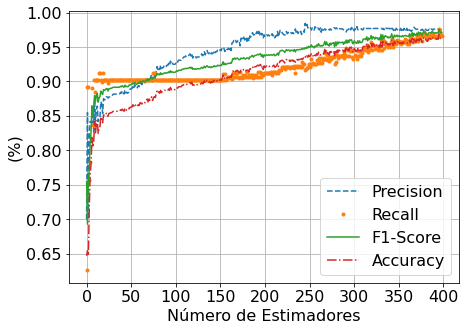

In [24]:
"""
* Análise a se fazer.
    * Acurácia, precisão, recall e F1 por estimador;
    * Curva Roc pelo melhor estimador.
"""

n_estimators = len(list(estimators.keys()))
corte = 400
n_keys = list(estimators.keys())[:corte]

accs = [ estimators[n]["acc"] for n in n_keys ][:corte]
precs = [ estimators[n]["prec"] for n in n_keys ][:corte]
recalls = [ estimators[n]["recall"] for n in n_keys ][:corte]
f1 = [ estimators[n]["f1"] for n in n_keys ][:corte]
x = list(range(n_estimators))[:corte]

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(x, precs, '--', label="Precision")
ax.plot(x, recalls, '.', label="Recall")
ax.plot(x, f1, label="F1-Score")
ax.plot(x, accs, '-.', label="Accuracy")
ax.legend(loc="lower right", fontsize=16)
ax.grid()
ax.set_xlabel("Número de Estimadores", fontsize=16)
ax.set_ylabel("(%)", fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig("results/scores.pdf")

#ax.set_ylim([0,1])

In [31]:
print(best_model, best_score, estimators[396])

best_precision = 0
prec_id = 0
for n in estimators:
    if estimators[n]["prec"] > best_precision:
        best_precision = estimators[n]["prec"]
        prec_id = n
print(best_precision, prec_id)

396 0.9759440251337798 {'acc': 0.9686354712041885, 'prec': 0.9762527161051591, 'recall': 0.9761493613640054, 'f1': 0.9759440251337798}
0.9844863234125485 246


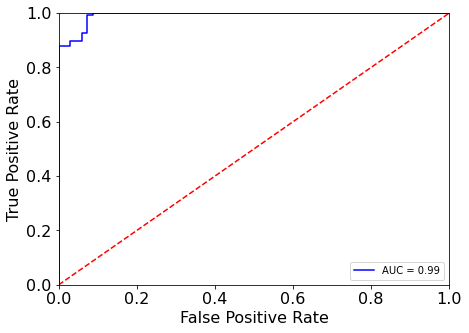

In [38]:
#seed = r.randint(0, 2147483647 * 2)
seed = 991726567
X_train, X_test, Y_train, Y_test = train_test_split(feats, target, test_size=0.2, shuffle=True, random_state=seed)

# Gerando o modelo.
adaboost = AdaBoost(best_model)
# Treinando o modelo.
adaboost.fit(X_train, Y_train)
# Testando o modelo.
Y_pred = adaboost.predict_proba(X_test)
# Criando curva ROC.
fpr, tpr, threshold = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(7,5))

ax.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax.legend(loc = 'lower right')
ax.plot([0, 1], [0, 1],'r--')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.set_xlabel('False Positive Rate', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.savefig("results/roc_auc.pdf")